# Decoding cell identity based on kinetic parameters of pancreatic endocrinogenesis data

This tutorial shows how to decode cell identity based on kinetic parameters using the predicted pancreatic endocrinogenesis data. For the pre-processing, by following the study of [Bergen et.al](https://www.nature.com/articles/s41587-020-0591-3), 3,696 cells with 2,000 genes are selected. 

## Import Packages

To run the notebook locally, create a conda environment as ```conda env create -n cellDancer python==3.7.6```, then install the dependencies by ```pip install -r requirements.txt``` using this [requirememts.txt](requirememts.txt).

In [6]:
%load_ext autoreload
%autoreload 2

import os
import glob
import random
import sys
import pandas as pd
import math
import matplotlib.pyplot as plt

# import from absolute directory
#srcdir = '/Users/pengzhizhang/cellDancer/src'
srcdir = '/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/bin/cellDancer_polish/src'
# srcdir = '/Users/wanglab/Documents/ShengyuLi/Velocity/bin/celldancer_polish/src'
# srcdir = '/Users/chen.weiqing/Documents/GitHub/cellDancer/src'
sys.path.append(srcdir)
import celldancer as cd
import celldancer.cdplt as cdplt
from celldancer.cdplt import colormap
from celldancer.velocity_estimation import velocity
from celldancer.compute_cell_velocity import compute
from celldancer.pseudo_time import pseudo_time
from celldancer.embedding_kinetic_para import embedding

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the velocity estimation result of all 2159 genes in pancreatic endocrinogenesis data

To display the prediction in the embedding level and to build the Uniform Manifold Approximation and Projection (UMAP) of kinetic parameters by using all genes, all the 2159 genes have already been predicted and could be downloaded from DentateGyrus_cellDancer_estimation.csv. The result was predicted from [PancreaticEndocrinogenesis.csv](link) with ```cd.velocity_estimation.velocity(cell_type_u_s, permutation_ratio=0.5, n_jobs=8)```.

The prediction result is online at [PancreaticEndocrinogenesis_cellDancer_estimation.csv](xxx). It could be loaded with ```pd.read_csv('your_path/PancreaticEndocrinogenesis_cellDancer_estimation.csv')```. 

In [2]:
#detail_result_path = '/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/pancreas/velocity_result/velocity_result_all_genes_with_bin/2000_smooth/combined_detail/combined_detail.csv'
#cellDancer_df_path = '/Users/wanglab/Documents/ShengyuLi/Velocity/data/pancreas/velocity_result/2000_smooth/velocity_result_all_genes_with_bin/combined_detail/combined_detail.csv'
cellDancer_df_path = '/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/pancreas/velocity_result/fin_parameter_0529/cell_dancer_velocity_2022-05-28 19-03-50/celldancer_estimation.csv'
#detail_result_path = '/Users/chen.weiqing/code/celldancer/pancreas/combined_detail.csv'

cellDancer_df=pd.read_csv(cellDancer_df_path)
cellDancer_df

,cellIndex,gene_name,unsplice,splice,unsplice_predict,splice_predict,alpha,beta,gamma,loss,cellID,clusters,embedding1,embedding2
0,0,Scaper,0.489151,0.211323,0.486841,0.185478,0.334391,0.629880,0.647696,0.043435,AAACCTGAGAGGGATA,Pre-endocrine,6.143066,-0.063644
1,1,Scaper,0.278262,0.125742,0.293904,0.107517,0.224909,0.626946,0.648537,0.043435,AAACCTGAGCCTTGAT,Ductal,-9.906417,0.197778
2,2,Scaper,0.374380,0.298116,0.348888,0.197525,0.213979,0.648890,0.665279,0.043435,AAACCTGAGGCAATTA,Alpha,7.559791,0.583762
3,3,Scaper,0.320497,0.198031,0.318165,0.146120,0.219611,0.636208,0.655523,0.043435,AAACCTGCATCATCCC,Ductal,-11.283765,4.218998
4,4,Scaper,0.239145,0.141970,0.251417,0.106599,0.192050,0.631560,0.652837,0.043435,AAACCTGGTAAGTGGC,Ngn3 high EP,1.721565,-4.753407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7391995,3691,Tmem63a,0.000000,0.136270,0.000447,0.125414,0.005472,0.110095,0.067564,0.045492,TTTGTCAAGTGACATA,Pre-endocrine,4.768472,-1.388353
7391996,3692,Tmem63a,0.028708,0.000000,0.021286,0.022931,0.017270,0.100517,0.072741,0.045492,TTTGTCAAGTGTGGCA,Ngn3 high EP,-1.873335,-4.182650
7391997,3693,Tmem63a,0.000000,0.312690,0.000200,0.288797,0.002445,0.116196,0.064809,0.045492,TTTGTCAGTTGTTTGG,Ductal,-9.882250,-0.105594
7391998,3694,Tmem63a,0.028052,0.154164,0.019519,0.165354,0.008143,0.107124,0.069812,0.045492,TTTGTCATCGAATGCT,Alpha,6.612424,4.531895


## Compute Cell Velocity

The prediction in the embedding level could be calculated with ```celldancer.compute_cell_velocity.compute()```. If not specified, all genes in cellDancer_df will be used to calculate the prediction in the embedding level. Following the method of [velocyto](link) and [scVelo](link), we project the velocity vectors of the cells into the low-dimensional embedding space. The probabilities of one cell transitioning into another cell are computed.

After the calculation, the predicted direction in the embedding level, i.e. columns 'velocity1' and 'velocity2' will be added to the original dataframe. ```cdplt.cell.scatter_cell()``` could be used to display the predicted direction in embedding level.

Caution! Overwriting the 'velocity' columns.


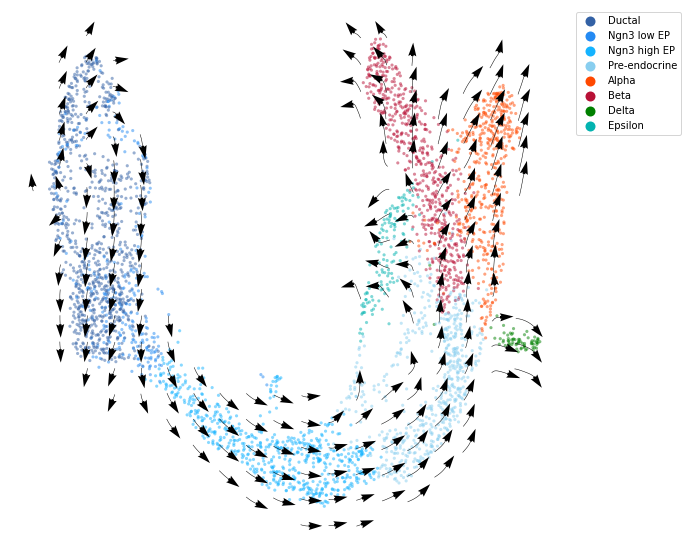

In [20]:
%autoreload 2

# Compute cell velocity
cellDancer_df=cd.compute_cell_velocity.compute(cellDancer_df=cellDancer_df, projection_neighbor_size=100)

# Plot cell velocity
fig, ax = plt.subplots(figsize=(10,10))
im = cdplt.cell.scatter_cell(ax, cellDancer_df, colors=colormap.colormap_pancreas, alpha=0.5, s=10, velocity=True, legend='on', min_mass=5, arrow_grid=(20,20))
ax.axis('off')
plt.show()

## Kinetic UMAP based on alpha, beta, and gamma

After obtaining the prediction result, ```celldancer.embedding_kinetic_para.embedding()``` could build the UMAP based on the predicted alpha, beta, gamma, or all of the three.

In [21]:
cellDancer_df=cd.embedding_kinetic_para.embedding(cellDancer_df,'alpha')
cellDancer_df=cd.embedding_kinetic_para.embedding(cellDancer_df,'beta')
cellDancer_df=cd.embedding_kinetic_para.embedding(cellDancer_df,'gamma')
cellDancer_df=cd.embedding_kinetic_para.embedding(cellDancer_df,'alpha_beta_gamma')

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


The UMAP could be visualized with ```cd.cdplt.cell.plot_kinetic_para``` depending on the selection of kinetic parameter(s). This result shows that our kinetic parameters could reflect cell identity. The spliced reads of one gene could be visualized when specifying the particular gene in ```cd.cdplt.cell.plot_kinetic_para()```.

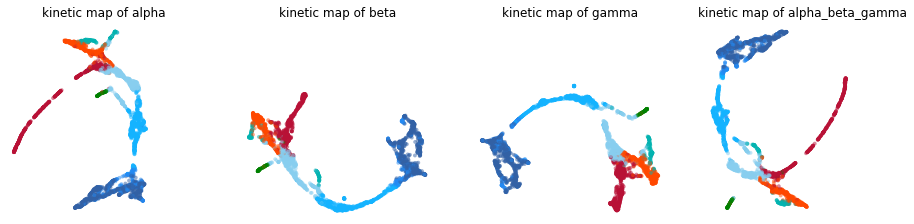

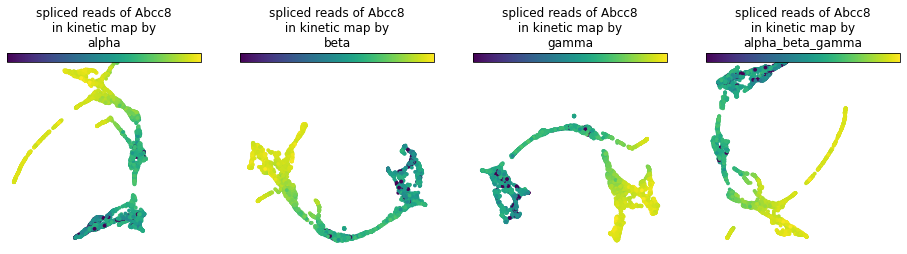

In [67]:
%autoreload 2
fig, ax = plt.subplots(ncols=4, figsize=(16,8))
cd.cdplt.cell.plot_kinetic_para(ax[0], 'alpha', cellDancer_df, color_map=cdplt.colormap.colormap_pancreas)
cd.cdplt.cell.plot_kinetic_para(ax[1], 'beta', cellDancer_df, color_map=cdplt.colormap.colormap_pancreas)
cd.cdplt.cell.plot_kinetic_para(ax[2], 'gamma', cellDancer_df, color_map=cdplt.colormap.colormap_pancreas)
cd.cdplt.cell.plot_kinetic_para(ax[3], 'alpha_beta_gamma', cellDancer_df, color_map=cdplt.colormap.colormap_pancreas)

gene='Abcc8'
fig, ax = plt.subplots(ncols=4, figsize=(16,8))
cd.cdplt.cell.plot_kinetic_para(ax[0], 'alpha', cellDancer_df, gene=gene, color_map=cdplt.colormap.colormap_pancreas)
cd.cdplt.cell.plot_kinetic_para(ax[1], 'beta', cellDancer_df, gene=gene, color_map=cdplt.colormap.colormap_pancreas)
cd.cdplt.cell.plot_kinetic_para(ax[2], 'gamma', cellDancer_df, gene=gene, color_map=cdplt.colormap.colormap_pancreas)
cd.cdplt.cell.plot_kinetic_para(ax[3], 'alpha_beta_gamma', cellDancer_df, gene=gene, color_map=cdplt.colormap.colormap_pancreas)